# TP5 : Systèmes linéaires et stabilité numérique

Dans ce TP, on étudiera les techniques de résolution de systèmes linéaires et on analysera leur stabilité numérique. On implémentera une telle méthode, basé sur la décomposition LU, qui sera stable et rapide. Ensuite on verra deux méthodes instables pour résoudre les systèmes linéaires : la règle de Cramer et le calcul direct de la matrice inverse. Enfin, on utilisera notre solveur pour résoudre l'équation de Poisson.

## Exercice 1 : Utilisation de la factorisation LU pour résoudre des systèmes linéaires

La factorisation LU peut être utilisée pour résoudre des systèmes linéaires. Soit $A$ une matrice carrée et $b$ un vecteur. On peut écrire $A = PLU$ où $P$ est une matrice de permutation, $L$ une matrice triangulaire inférieure et $U$ une matrice triangulaire supérieure. On peut donc résoudre le système linéaire $Ax = b$ en résolvant deux systèmes triangulaires. 

Un système triangulaire peut être résolu en utilisant la substitution, comme montré après l'équation (5.9) du polycopié. On peut toujours supposer que tous les éléments diagonaux des matrices $L$ et $U$ sont non nuls. 


### Exercice 1a)
> Implémentez les fonctions `solve_triu` et `solve_tril` qui résolvent, respectivement, le système triangulaire supérieur $Ux = b$ et le système triangulaire inférieur $Ly = b$. 
---

In [ ]:
import numpy as np


def solve_triu(U, b):
    """
    Résout Ux = b où U est carré et triangulaire supérieur.

    On suppose que toutes les entrées diagonales de U sont différentes de zéro.
    b est un vecteur.
    """
    # VOTRE CODE ICI
    n = U.shape[0]
    x = np.zeros(n)
    for i in range(n - 1, -1, -1):
        x[i] = (b[i] - np.dot(U[i, i + 1 :], x[i + 1 :])) / U[i, i]
    return x


def solve_tril(L, b):
    """
    Résout Ux = b où U est carré et triangulaire inférieur.

    On suppose que toutes les entrées diagonales de U sont différentes de zéro.
    b est un vecteur.
    """
    # VOTRE CODE ICI
    n = L.shape[0]
    x = np.zeros(n)
    for i in range(n):
        x[i] = (b[i] - np.dot(L[i, :i], x[:i])) / L[i, i]
    return x


In [ ]:
def test_solve_triu_tril():
    for n in (2, 5, 10):
        A = np.random.normal(size=(n, n))
        U = np.triu(A)
        x_true = np.random.normal(size=n)
        b = U @ x_true
        x = solve_triu(U, b)
        assert x.shape == (n,), "x n'a pas la bonne taille pour solve_triu"
        assert np.linalg.norm(U @ x - b) < 1e-10, "Ux != b pour solve_triu"

        L = np.tril(A)
        x = solve_tril(L, b)
        assert x.shape == (n,), "x n'a pas la bonne taille pour solve_tril"
        assert np.linalg.norm(L @ x - b) < 1e-10, "Ux != b pour solve_tril"


test_solve_triu_tril()


On peut obtenir la factorisation LU d'une matrice en utilisant `scipy.linalg.lu`. La fonction renvoie la matrice de permutation $P$, la matrice triangulaire inférieure $L$ et la matrice triangulaire supérieure $U$ :

In [ ]:
import scipy.linalg

A = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

P, L, U = scipy.linalg.lu(A)
print("P = \n", P)
print("L = \n", L)
print("U = \n", U)

print("P @ L @ U = \n", P @ L @ U)


P = 
 [[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]
L = 
 [[1.         0.         0.        ]
 [0.14285714 1.         0.        ]
 [0.57142857 0.5        1.        ]]
U = 
 [[7.00000000e+00 8.00000000e+00 9.00000000e+00]
 [0.00000000e+00 8.57142857e-01 1.71428571e+00]
 [0.00000000e+00 0.00000000e+00 1.11022302e-16]]
P @ L @ U = 
 [[1. 2. 3.]
 [4. 5. 6.]
 [7. 8. 9.]]


### Exercice 1b)
> Implémentez une fonction `solve_lu` qui résout un système linéaire $Ax = b$ en utilisant la factorisation LU de la forme $A=PLU$.
> Utilisez les fonctions `solve_triu` et `solve_tril` pour résoudre les systèmes triangulaires.
---

_Si vous n'avez pas réussi à résoudre l'exercice 1a), vous pouvez utiliser les fonctions `scipy.linalg.solve_triangular(A, b, lower=False)` et `scipy.linalg.solve_triangular(A, b, lower=True)` pour résoudre respectivement un système triangulaire supérieur et inférieur._

In [ ]:
import scipy.linalg


def solve_lu(A, b):
    """
    Résout Ax = b où A est un carré en utilisant la décomposition LU.

    Retourne un vecteur x de même forme que b.
    """
    P, L, U = scipy.linalg.lu(A)

    # VOTRE CODE ICI
    x = solve_tril(L, P.T @ b)
    x = solve_triu(U, x)
    return x



In [ ]:
def test_solve_lu():
    for n in range(1, 30):
        A = np.random.normal(size=(n, n))
        x_true = np.random.normal(size=n)
        b = A @ x_true
        x = solve_lu(A, b)
        assert x.shape == (n,), "x n'a pas la bonne taille pour solve_lu"
        assert np.linalg.norm(A @ x - b) < 1e-10, "Ax != b pour solve_lu"

test_solve_lu()

> _À partir de maintenant, si vous n'avez pas réussi à résoudre l'exercice 1b), vous pouvez utiliser la fonction `np.linalg.solve` pour résoudre les systèmes linéaires au lieu de `solve_lu`._ 

## Exercice 2 : Règle de Cramer

On peut résoudre les systèmes linéaires $Ax=b$ en utilisant la règle de Cramer
$$
    x_i = \frac{\det(A_i)}{\det(A)}, \quad i=1,\dots,n
$$
où $A_i$ est la matrice obtenue à partir de $A$ en remplaçant la $i$-ième colonne par $b$. 

Pour utiliser cette méthode, il faut disposer d'un moyen efficace de calculer le déterminant d'une matrice. La formule combinatoire, ou l'expansion de Laplace, à laquelle vous êtes peut-être habitué lorsque vous calculez les déterminants à la main, est très coûteuse à calculer (elle coûte $O(n !)$ flops). À la place, on peut utiliser la factorisation LU pour calculer le déterminant d'une matrice. Si l'on écrit $A = PLU$, on a alors
$$
    \det(A) = \det(P)\det(L)\det(U).
$$
Il est facile de vérifier à partir de la définition que le déterminant d'une matrice triangulaire est simplement le produit des entrées diagonales. Le déterminant d'une matrice de permutation dépend de la parité de la permutation et est soit $1$ (paire) soit $-1$ (impaire). Par conséquent, on peut calculer le déterminant d'une matrice en calculant sa factorisation LU, puis en multipliant les diagonales de $L$ et $U$ et le signe de $P$. 

### Exercice 2a)
> Implémentez une fonction `det` qui calcule le déterminant d'une matrice en utilisant la décomposition LU.
>
> Vous pouvez utiliser la fonction `permutation_signature` qui calcule la signature (et donc le déterminant) d'une matrice de permutation.
---

In [ ]:
def permutation_signature(P):
    """
    Calculer le déterminant d'une matrice de permutation.
    """
    from sympy.combinatorics import Permutation

    perm = Permutation(np.nonzero(P)[1])  # convertir en permutation sympy
    sign = perm.signature()
    return sign


def det(A):
    """
    Calculer le déterminant d'une matrice carrée A en utilisant la décomposition LU.
    """
    # VOTRE CODE ICI

    # Le diagonal de L est toujours 1, donc on peut l'ignorer.
    P, _, U = scipy.linalg.lu(A)
    return np.prod(np.diag(U)) * permutation_signature(P)


In [ ]:
def test_det():
    for n in range(1, 30):
        A = np.random.normal(size=(n, n))
        assert (
            abs(np.linalg.det(A) - det(A)) / abs(np.linalg.det(A)) < 1e-5
        ), "det(A) != np.linalg.det(A)"


test_det()


### Exercice 2b)
> Implémentez une fonction `solve_cramer` qui résout un système linéaire $Ax=b$ en utilisant la règle de Cramer. 
----

_Vous pouvez utiliser la fonction `np.linalg.det` pour calculer le déterminant d'une matrice si vous n'avez pas réussi à résoudre 2a)._

In [ ]:
def solve_cramer(A, b):
    """
    Résout Ax = b en utilisant la règle de Cramer.
    """
    n = A.shape[0]

    # VOTRE CODE ICI
    x = np.zeros(n)
    det_A = det(A)
    for i in range(n):
        A_i = A.copy()
        A_i[:, i] = b
        x[i] = det(A_i) / det_A
    return x


In [ ]:
def test_solve_cramer():
    for n in range(1, 30):
        A = np.random.normal(size=(n, n))
        x_true = np.random.normal(size=n)
        b = A @ x_true
        x = solve_cramer(A, b)
        assert x.shape == (n,), "x n'a pas la bonne taille pour solve_cramer"
        assert np.linalg.norm(A @ x - b) < 1e-10, "Ax != b pour solve_cramer"


test_solve_cramer()


La règle de Cramer a deux problèmes : elle est relativement lente et n'est pas numériquement stable. Considérons le premier problème en chronométrant l'exécution de la règle de Cramer sur une matrice aléatoire $A$ et un vecteur aléatoire $b$, par rapport à `solve_lu`. 

In [ ]:
from time import perf_counter

# perf_counter est un fonction précise qui retourne le temps en secondes

n = 100
A = np.random.normal(size=(n, n))
b = np.random.normal(size=n)

temps_avant = perf_counter()
solve_lu(A, b)
temps_lu = perf_counter() - temps_avant
print(f"temps de solve_lu: {temps_lu:.3e} s")

temps_avant = perf_counter()
solve_cramer(A, b)
temps_cramer = perf_counter() - temps_avant
print(f"temps de solve_cramer: {temps_cramer:.3e} s")

print(
    f"solve_lu est {temps_cramer / temps_lu:.1f} fois plus rapide que solve_cramer"
)


temps de solve_lu: 1.180e-03 s
temps de solve_cramer: 4.000e-02 s
solve_lu est 33.9 fois plus rapide que solve_cramer


Ensuite, on étudiera la stabilité de la règle de Cramer par rapport à la méthode utilisant la factorisation LU. Pour ce faire, on peut calculer l'erreur forward et le résidu pour les systèmes de la forme $Ax=b$ où $A$ est une matrice aléatoire avec une condition $\kappa$ donnée. Si $\hat x$ est une solution perturbée de $Ax=b$, alors la stabilité forward peut être mesurée par l'erreur relative
$$
    E_f = \frac{\|x - \hat x\|_2}{\|x\|_2}
$$
La stabilité backward peut être mesurée par le résidu relative
$$
    E_b = \frac{\|A\hat x - b\|_2}{\|b\|_2}
$$

Pour voir comment les deux méthodes se comportent, on peut tracer ces deux erreurs en fonction du conditionnement de $A$. On peut générer une matrice aléatoire avec une condition `cond` donnée en utilisant la fonction `random_matrix` définie ci-dessous. 

In [ ]:
def random_matrix(n, cond):
    """
    Créez une matrice aléatoire (n, n) avec conditionnement `cond`.
    """
    A = np.random.normal(size=(n, n))
    U, _, V = np.linalg.svd(A)
    S = np.diag(np.logspace(0, -np.log10(cond), n))
    return U @ S @ V


# Crée une matrice aléatoire avec conditionnement 10
A = random_matrix(5, 10)
np.linalg.cond(A)


10.000000000000002

### Exercice 2c)
> Comparez l'erreur forward et le résidu pour la règle de Cramer et la factorisation LU pour les systèmes $Ax=b$ où $A$ est une matrice aléatoire avec un conditionnement spécifié. 
> Pour ce faire, complétez les quatre fonctions ci-dessous conformément à leur description. 
>
> Vous pouvez utiliser la fonction `random_matrix(n, cond)` définie ci-dessus pour générer une matrice aléatoire avec un conditionnement spécifié.
---

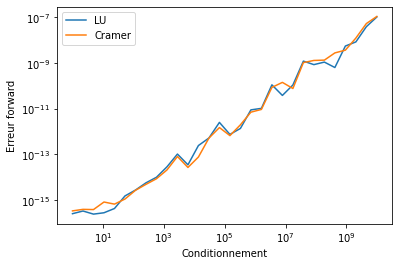

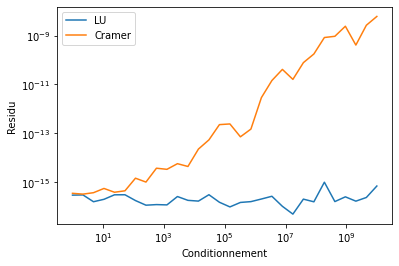

In [ ]:
import matplotlib.pyplot as plt
import numpy as np 


def forward_error(x_true, x_estim):
    """Calcule l'erreur relative forward E_f définie ci-dessus."""

    # VOTRE CODE ICI
    return np.linalg.norm(x_true - x_estim) / np.linalg.norm(x_true)


def residual_error(A, b, x_true, x_estim):
    """Calcule le residu E_b définie ci-dessus."""

    # VOTRE CODE ICI
    res = np.linalg.norm(A @ x_estim - b)

    return res / np.linalg.norm(b)


def plot_forward_errors(n, condition_numbers, solve_method, nom):
    """
    Tracez l'erreur forward E_f en fonction du conditionnement pour
    une méthode de résolution donnée.

    Paramètres
    ----------
    n : La taille de la matrice A.
    condition_numbers : Une liste des conditionnements.
    solve_method : Une fonction qui prend A et b comme arguments et retourne un solution approximatif.
    nom : Le nom de la méthode de résolution, et le label utilisé pour la légende du tracé.
    """
    np.random.seed(179)  # fixer la seed pour pouvoir reproduire ses résultats

    # VOTRE CODE ICI

    forward_errors = []
    for cond in condition_numbers:
        A = random_matrix(n, cond)
        x_true = np.random.normal(size=n)
        b = A @ x_true
        x_estim = solve_method(A, b)
        forward_errors.append(forward_error(x_true, x_estim))
    plt.plot(condition_numbers, forward_errors, label=nom)


def plot_residual_errors(n, condition_numbers, solve_method, nom):
    """
    Tracez le residu E_b en fonction du conditionnement pour une
    méthode de résolution donnée.


    Parameters
    ----------
    n : La taille de la matrice A.
    condition_numbers : Une liste des conditionnements.
    solve_method : Une fonction qui prend A et b comme arguments et retourne un solution approximatif.
    nom : Le nom de la méthode de résolution, et le label utilisé pour la légende du tracé.
    """
    np.random.seed(179)  # fixer la seed pour pouvoir reproduire ses résultats

    # VOTRE CODE ICI

    residual_errors = []
    for cond in condition_numbers:
        A = random_matrix(n, cond)
        x_true = np.random.normal(size=n)
        b = A @ x_true
        x_estim = solve_method(A, b)
        residual_errors.append(residual_error(A, b, x_true, x_estim))
    plt.plot(condition_numbers, residual_errors, label=nom)


n = 10
condition_numbers = np.logspace(0, 10, 30)

plot_forward_errors(n, condition_numbers, solve_lu, "LU")
plot_forward_errors(n, condition_numbers, solve_cramer, "Cramer")
plt.xlabel("Conditionnement")
plt.ylabel("Erreur forward")
plt.legend()
plt.loglog()

plt.figure()
plot_residual_errors(n, condition_numbers, solve_lu, "LU")
plot_residual_errors(n, condition_numbers, solve_cramer, "Cramer")
plt.xlabel("Conditionnement")
plt.ylabel("Residu")
plt.legend()
plt.loglog()
plt.show()


> **Réflexion:** Est-ce que cela correspond à ce que vous attendiez ? Pourquoi l'erreur forward augmente-t-elle à la même vitesse pour la méthode utilisant la règle de Cramer et la méthode LU, alors que le résidu relatif croît beaucoup plus rapidement pour la méthode utilisant la règle de Cramer ?

_Solution : On s'attend à ce que l'erreur forward augmente proportionnellement au conditionnement. En effet, le conditionnement caractérise précisément la variation de l'erreur directe par rapport à de petites perturbations. Le résidu relatif montre que la méthode LU est stable, alors que la méthode utilisant la règle de Cramer n'est pas (backwards) stable. Les raisons précises pour lesquelles l'une est stable et l'autre non n'est cependant pas évidente._


In [ ]:
def test_forward_error():
    x = np.arange(10)
    assert (
        forward_error(x, x) < 1e-10
    ), "forward_error ne retourne pas 0 pour x_true = x_estim"
    y = x + 1
    assert (
        abs(forward_error(x, y) - np.sqrt(10) / np.linalg.norm(x)) < 1e-8
    ), "forward_error ne retourne pas la bonne valeur"
    assert (
        forward_error(x, y) > 0
    ), "forward_error ne retourne pas une valeur positive"


test_forward_error()


def test_residual_error():
    for n in [5, 10, 20]:
        A = np.random.normal(size=(n, n))
        x_true = np.random.normal(size=n)
        b = A @ x_true
        x_estim = x_true
        assert (
            residual_error(A, b, x_true, x_estim) < 1e-10
        ), "residual_error ne retourne pas 0 pour x_true = x_estim"
        x_estim = np.random.normal(size=n)
        assert (
            residual_error(A, b, x_true, x_estim) > 0
        ), "residual_error ne retourne pas une valeur positive"

        A = np.eye(n)
        x_true = np.ones(n)
        b = A @ x_true
        x_estim = x_true + 1
        assert (
            abs(residual_error(A, b, x_true, x_estim) - 1) < 1e-8
        ), "residual_error ne retourne pas la bonne valeur"


test_residual_error()


## Exercice 3 : Un faux-pas numérique : utiliser l'inverse pour résoudre des systèmes linéaires.

On peut résoudre des systèmes linéaires $Ax=b$ en utilisant l'inverse de $A$ : $x = A^{-1}b$. Cependant, ce n'est pas une bonne idée car cette méthode n'est pas numériquement stable. On étudiera cela en calculant l'erreur directe et le résidu pour les systèmes $Ax=b$ où $A$ est une matrice aléatoire avec un conditionnement spécifié.

### Exercice 3a)
> Implémentez une fonction `matrix_inverse(A)` qui calcule l'inverse de `A` en utilisant la méthode d'élimination de Gauss. Pour cela on peut s'aider de la décomposition LU, en effet, en utilisant `solve_lu`, on peut résoudre les systèmes linéaires $Ax_i = e_i$, où $e_i$ est le $i$-ième vecteur unitaire, et ainsi calculer l'inverse de $A$ colone par colone. Implémentez ensuite une fonction `solve_inverse` qui résout un système linéaire $Ax=b$ en utilisant l'inverse de $A$ calculé par `matrix_inverse`.
>
> Vous pouvez utiliser la fonction `np.eye(n)` pour construire une matrice identité de taille $n$.
---

In [ ]:
def matrix_inverse(A):
    """
    Calculez l'inverse de A en utilisant la décomposition LU.
    """
    n = A.shape[0]

    # VOTRE CODE ICI
    I = np.eye(n)
    A_inv = np.zeros((n, n))
    for i in range(n):
        A_inv[:, i] = solve_lu(A, I[:, i])
    return A_inv


def solve_inverse(A, b):
    """
    Résout Ax = b en utilisant l'inverse de A.
    """
    # VOTRE CODE ICI
    A_inv = matrix_inverse(A)
    return A_inv @ b


In [ ]:
def test_matrix_inverse():
    for n in [2, 5, 10]:
        A = np.random.normal(size=(n, n))
        A_inv = matrix_inverse(A)
        assert A_inv.shape == (n, n), "A_inv n'est pas de la bonne taille"
        assert np.linalg.norm(A @ A_inv - np.eye(n)) < 1e-10, "A@A_inv != I"
        assert np.linalg.norm(A_inv @ A - np.eye(n)) < 1e-10, "A_inv@A != I"


test_matrix_inverse()


def test_solve_inverse():
    for n in range(1, 30):
        A = np.random.normal(size=(n, n))
        x_true = np.random.normal(size=n)
        b = A @ x_true
        x = solve_inverse(A, b)
        assert x.shape == (n,), "x n'est pas de la bonne taille"
        assert np.linalg.norm(A @ x - b) < 1e-10, "Ax != b pour solve_inverse"


test_solve_inverse()


En utilisant les fonctions de l'exercice 2c), on peut analyser la stabilité de la méthode inverse, et on observe qu'elle se comporte de manière très similaire à la règle de Cramer.

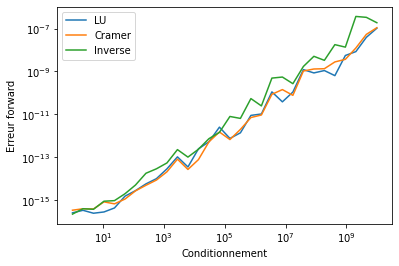

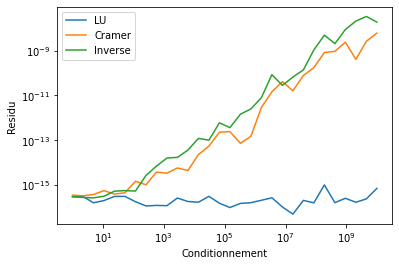

In [ ]:
n = 10
condition_numbers = np.logspace(0, 10, 30)

plot_forward_errors(n, condition_numbers, solve_lu, "LU")
plot_forward_errors(n, condition_numbers, solve_cramer, "Cramer")
plot_forward_errors(n, condition_numbers, solve_inverse, "Inverse")
plt.xlabel("Conditionnement")
plt.ylabel("Erreur forward")
plt.legend()
plt.loglog()

plt.figure()
plot_residual_errors(n, condition_numbers, solve_lu, "LU")
plot_residual_errors(n, condition_numbers, solve_cramer, "Cramer")
plot_residual_errors(n, condition_numbers, solve_inverse, "Inverse")
plt.xlabel("Conditionnement")
plt.ylabel("Residu")
plt.legend()
plt.loglog()
plt.show()


## Exercice 4: Équation de Poisson en dimension 1

Prenons une fine barre métallique homogène de longueur $L$ et de section constante. On suppose que la barre est thermiquement isolée, de telle manière que la chaleur se propage uniquement suivant la barre. On applique une source thermique extérieure $H(x)$ tout au long de la barre. On pose $u(x,t)$ la température au point $x$ de la barre et au temps $t$. Alors en appliquant le principe de conservation de l'énergie, on obtient l'équation suivante, appelée équation de la chaleur 1D:
$$
    \frac{\partial u(x,t)}{\partial t} =\alpha^2 \, \frac{\partial^2 u(x,t)}{\partial^2 x} +H(x), \qquad x\in [0,L], \quad t>0,
$$
où $\alpha^2$ est le coefficient de diffusion. On suppose aussi que les extrémités de la barre sont maintenues à une température nulle,
$$
    u(0,t) = u(L,t)=0.
$$
Si la température initiale est donnée par $g(x)$, alors on a
$$
    u(x,0)= g(x) \qquad \text{avec}\qquad g(0)=g(L)=0. 
$$
À présent, on s'intéresse aux solutions stationnaires de cette équation, c'est à dire les solutions vérifiant $\frac{\partial u(x,t)}{\partial t}=0$. L'équation de la chaleur stationnaire ainsi obtenue est appelée équation de Poisson. À présent, la température ne dépend plus du temps $t$. Si l'on appelle la température $\phi(x)$ et la source de chaleur extérieure $F(x)$, l'équation de Poisson est donnée par
$$
    -\, \frac{\partial^2 \phi(x)}{\partial^2 x} = F(x), \qquad x\in [0,L],\tag{$*$}
$$
$$
    \phi(0) = \phi(L)=0.
$$
Pour résoudre $(*)$ numériquement, on divise l'intervalle $[0,L]$ en $n$ sous-intervalles de longueur $h=L/n$ avec $0=x_{0}<x_{1}<...<x_{n}<x_{n}=L$. On utilise alors un schéma de différences finies pour approcher $\phi_{xx}:= \frac{\partial^2 \phi(x)}{\partial^2 x}$, et on obtient finalement

$$
\frac{1}{h^2} \begin{pmatrix} 2 & -1\\-1 & 2 & -1\\ & -1 & \ddots & \ddots\\
& & \ddots & \ddots & -1\\
& & & -1 & 2 \end{pmatrix} \begin{pmatrix}
\phi_{1} \\
\phi_{2}\\
\vdots\\
\phi_{n-2}\\
\phi_{n-1}
\end{pmatrix} = \begin{pmatrix}
F_{1} \\
F_{2}\\
\vdots\\
F_{n-2}\\
F_{n-1}
\end{pmatrix},\tag{$**$}
$$
où $F_{i}=F(x_{i})$. 

On résoudra $(**)$ numériquement en utilisant la factorisation LU. Pour comparer les résultats à la solution exacte, on peut choisir un $\phi$ satisfaisant $(*)$ et calculer $F$ à partir de celui-ci. On utilisera la fonction suivante pour calculer $F$ à partir de $\phi$ :
$$
    \phi(x) = x(x-L) + 2\sin(\pi x/L)
$$
On utilisera `sympy` pour calculer sa dérivée et la stocker comme une fonction :

In [ ]:
from sympy.abc import x
from sympy import lambdify, sin, pi

L = 1

# Phi et F comme expression sympy
phi_sympy = x * (x - L) + 2 * sin(pi * x / L)
F_sympy = -phi_sympy.diff(x, 2)
print("phi =", phi_sympy)
print("  F =", F_sympy)

# Assurer que phi(0)=phi(L)=0
assert phi_sympy.subs(x, 0) == 0
assert phi_sympy.subs(x, L) == 0

# On convertit les expressions sympy en fonctions qui acceptent des arrays numpy
phi = lambdify(x, phi_sympy, "numpy")
F = lambdify(x, F_sympy, "numpy")


phi = x*(x - 1) + 2*sin(pi*x)
  F = -2*(-pi**2*sin(pi*x) + 1)


### Exercise 4a)
> Implémentez une fonction `solve_poisson` qui résout l'équation de Poisson stationnaire. Assurez-vous d'utiliser les bons points d'échantillonnage $x_1,\dots,x_{n-1}$, en omettant $x_0=0$ et $x_n=L=1$.
----

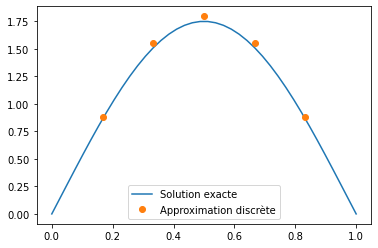

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 

def solve_poisson(F, L, n):
    """
    Calcule la solution stationnaire de l'équation de Poisson -phi'' = F sur [0, L].

    F : Une fonction représentant la source de chaleur externe
    L : Longueur de la barre
    n : Nombre de points dans la discrétisation
    """
    # VOTRE CODE ICI
    x = np.linspace(0, L, n + 1)[1:-1]
    h = L / n
    A = (
        2 * np.eye(n - 1)
        - np.diag(np.ones(n - 2), k=-1)
        - np.diag(np.ones(n - 2), k=1)
    )
    A /= h**2

    sample_F = F(x)
    return solve_lu(A, sample_F)


plot_x = np.linspace(0, L, 40)
plt.plot(plot_x, phi(plot_x), label="Solution exacte")

# Les points [x_1, ..., x_(n-1)] de la discrétisation
n = 6
x_discret = np.linspace(0, L, n + 1)[1:-1]

sol_discret = solve_poisson(F, L, n)

plt.plot(x_discret, sol_discret, "o", label="Approximation discrète")
plt.legend()
plt.show()


In [ ]:
def test_solve_poisson():
    L = 1
    for n in [5, 6, 10, 20]:
        sample_x = np.linspace(0, L, n + 1)[1:-1]
        sol = solve_poisson(F, L, n)
        assert sol.shape == (n - 1,), "La solution n'est pas de la bonne taille"
        assert (
            np.linalg.norm(sol - sol[::-1]) < 1e-10
        ), "La solution doit être symétrique si F est symétrique"
        assert (
            np.max(np.abs(sol - phi(sample_x))) < 0.1
        ), "La solution n'est pas sufficement proche de la solution exacte"

    L = 2
    from sympy import exp

    phi_sympy = x * (x - L) + 2 * sin(pi * x / L) + exp(x * (x - L)) - 1
    assert phi_sympy.subs(x, 0) == 0
    assert phi_sympy.subs(x, L) == 0
    F_sympy = -phi_sympy.diff(x, 2)

    phi_new = lambdify(x, phi_sympy, "numpy")
    F_new = lambdify(x, F_sympy, "numpy")

    for n in [10, 15, 20]:
        sample_x = np.linspace(0, L, n + 1)[1:-1]
        sol = solve_poisson(F_new, L, n)
        sol - phi_new(sample_x)
        try:
            assert sol.shape == (
                n - 1,
            ), "La solution n'est pas de la bonne taille"
            assert (
                np.linalg.norm(sol - sol[::-1]) < 1e-10
            ), "La solution doit être symétrique si F est symétrique"
            assert (
                np.max(np.abs(sol - phi_new(sample_x))) < 0.1
            ), "La solution n'est pas sufficement proche de la solution exacte"
        except AssertionError:
            print(
                "Le code est correct pour L, F, phi comme ci-dessus, mais",
                "donne une erreur pour une valeur différente de L, F et phi.",
            )
            raise


test_solve_poisson()


### Exercice 4b)
On peut mesurer la précision de la solution en calculant la déviation maximale
$$
\max_{i=1,\dots,n-1} \| \hat \phi(x_i) - \phi_i\|
$$
où $\hat \phi$ est la solution exacte de l'équation de Poisson, et $\phi_i$ est la solution numérique à $x_i$.

---
> En utilisant les mêmes $L$, $F$ et $\phi$ que dans l'exercice précédent, étudier la convergence de la méthode en traçant la déviation maximale en fonction de $n$ pour différentes valeurs de $h$. 
>
> Comparez la convergence à $1/n^2$.
---

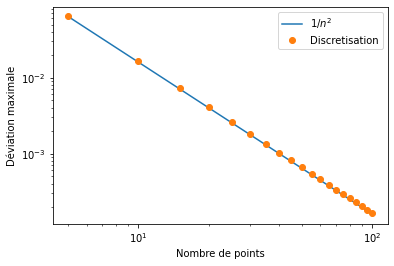

In [ ]:
# VOTRE CODE ICI

max_errors = []
n_values = np.arange(5, 101, 5)
for n in n_values:
    x_discret = np.linspace(0, L, n + 1)[1:-1]
    sol_discret = solve_poisson(F, L, n)
    max_errors.append(np.max(np.abs(sol_discret - phi(x_discret))))

plt.loglog()
plt.plot(
    n_values, max_errors[0] * n_values[0] ** 2 / n_values**2, label="$1/n^2$"
)
plt.plot(n_values, max_errors, "o", label="Discretisation")
plt.xlabel("Nombre de points")
plt.ylabel("Déviation maximale")
plt.legend()
plt.show()


### Exercice 4c)
Observez que la matrice du côté gauche de $(**)$ est tridiagonale, et que la plupart des entrées sont donc nulles. On peut utiliser cela à notre avantage dans le cas où $n$ est très grand (disons $n>10\,000$). Dans ce cas, on peut utiliser la fonction scipy `solve_banded` pour résoudre le système linéaire $Ax=b$ sans jamais stocker la matrice entière $A$ en mémoire ; on ne stocke que les diagonales non nulles. La syntaxe de `solve_banded` est la suivante
```python
    solve_banded((lower, upper), A, b)
```
où `lower` et `upper` sont le nombre de sous- et super-diagonales de $A$ respectivement, et `A` est un tableau 2D contenant les diagonales non nulles de $A$ dans l'ordre suivant. Dans le cas que l'on considère, cela signifie que `lower` et `upper` sont `1` et que `A` est une matrice de forme `(3, n - 1)`, où chaque ligne est constante. 

_Plus généralement, nous pouvons représenter `A` comme une matrice creuse (anglais: 'sparse matrix'), ce qui signifie que nous ne stockons que les entrées non nulles. Il existe de nombreuses techniques pour résoudre des problèmes linéaires avec une matrice creuse, qui tirent généralement avantage du fait que le calcul des produits matrice-vecteur $Av$ est peu coûteux, même pour de très grandes matrices creuses. Dans l'équation (**), `A` n'est pas n'importe quelle matrice creuse ; ses entrées non nulles suivent un modèle très spécifique que l'on peut utiliser pour développer un solveur linéaire spécialisé très efficace._

----
> Implémentez une fonction `solve_poisson_sparse` avec la même syntaxe que `solve_poisson`, et qui résout l'équation de Poisson stationnaire en utilisant la fonction `solve_banded`. 
> 
> La fonction devrait calculer la réponse très rapidement, même pour de grandes valeurs de $n$ telles que $n=1\,000\,000$.
----

In [ ]:
import scipy.linalg


def solve_poisson_sparse(F, L, n):
    """
    Calcule la solution stationnaire de l'équation de Poisson -phi'' = F sur [0, L].

    Utilise `solve_banded` pour résoudre efficacement le problème linéaire pour
    de grandes valeurs de n

    F : Une fonction représentant la source de chaleur externe
    L : Longueur de la barre
    n : Nombre de points dans la discrétisation
    """
    # VOTRE CODE ICI
    x = np.linspace(0, L, n + 1)[1:-1]
    h = L / n
    A = np.zeros((3, n - 1))
    A[0, :] = -1
    A[1, :] = 2
    A[2, :] = -1
    A /= h**2

    sample_F = F(x)
    return scipy.linalg.solve_banded((1, 1), A, sample_F)


# Cela devrait fonctionner sans erreur de mémoire
solve_poisson_sparse(F, L, 1_000_000)


array([5.28318628e-06, 1.05663746e-05, 1.58495649e-05, ...,
       1.58495649e-05, 1.05663746e-05, 5.28318629e-06])

In [ ]:
def test_solve_poisson_sparse():
    L = 1
    for n in [1_000_000, 1000, 10_000, 100_000]:
        sample_x = np.linspace(0, L, n + 1)[1:-1]
        try:
            sol = solve_poisson_sparse(F, L, n)
        except MemoryError:
            print(
                f"Il n'y a plus de mémoire. Ne formez pas la matrice complète !"
            )
            raise
        assert sol.shape == (n - 1,), "La solution n'est pas de la bonne taille"
        assert (
            np.linalg.norm(sol - sol[::-1]) / np.linalg.norm(sol) < 1e-6
        ), "La solution doit être symétrique si F est symétrique"
        assert (
            np.max(np.abs(sol - phi(sample_x))) < 0.1
        ), "La solution n'est pas sufficement proche de la solution exacte"

    L = 2
    from sympy import exp

    phi_sympy = x * (x - L) + 2 * sin(pi * x / L) + exp(x * (x - L)) - 1
    assert phi_sympy.subs(x, 0) == 0
    assert phi_sympy.subs(x, L) == 0
    F_sympy = -phi_sympy.diff(x, 2)

    phi_new = lambdify(x, phi_sympy, "numpy")
    F_new = lambdify(x, F_sympy, "numpy")

    for n in [1_000_000, 1000, 10_000, 100_000]:
        sample_x = np.linspace(0, L, n + 1)[1:-1]
        sol = solve_poisson_sparse(F_new, L, n)
        sol - phi_new(sample_x)
        assert sol.shape == (n - 1,), "La solution n'est pas de la bonne taille"
        assert (
            np.linalg.norm(sol - sol[::-1]) / np.linalg.norm(sol) < 1e-6
        ), "La solution doit être symétrique si F est symétrique"
        assert (
            np.max(np.abs(sol - phi_new(sample_x))) < 0.1
        ), "La solution n'est pas sufficement proche de la solution exacte"


test_solve_poisson_sparse()
